In [ ]:
# !pip install rouge_score

In [ ]:
# mount google drive to access/load the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Input, Bidirectional, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Load the dataset
def load_data(file_path):
    articles = []
    summaries = []
    with open(file_path, 'r') as f:
        for line in f:
            data = json.loads(line)
            # First join words in each sentence, then join sentences in each paragraph
            article_text = ' '.join([' '.join(sentence) for paragraph in data['paragraphs'] for sentence in paragraph])
            summary_text = ' '.join([' '.join(sentence) for sentence in data['summary']])
            articles.append(article_text)
            summaries.append(summary_text)
    return articles, summaries


# Paths to one of the dataset's JSONL files (adjust for different folds)
train_file = '/content/drive/MyDrive/Dataset/indosum/train.01.jsonl'
dev_file = '/content/drive/MyDrive/Dataset/indosum/dev.01.jsonl'
test_file = '/content/drive/MyDrive/Dataset/indosum/test.01.jsonl'

# Load data
train_articles, train_summaries = load_data(train_file)
dev_articles, dev_summaries = load_data(dev_file)
test_articles, test_summaries = load_data(test_file)

In [ ]:
print(f"jumlah data : {len(train_articles)}")
print(f"contoh artikel : {train_articles[0]}")
print(f"contoh summary artikel : {train_summaries[0]}")

jumlah data : 14262
contoh artikel : Jakarta , CNN Indonesia - - Dokter Ryan Thamrin , yang terkenal lewat acara Dokter Oz Indonesia , meninggal dunia pada Jumat ( 4 / 8 ) dini hari . Dokter Lula Kamal yang merupakan selebriti sekaligus rekan kerja Ryan menyebut kawannya itu sudah sakit sejak setahun yang lalu . Lula menuturkan , sakit itu membuat Ryan mesti vakum dari semua kegiatannya , termasuk menjadi pembawa acara Dokter Oz Indonesia . Kondisi itu membuat Ryan harus kembali ke kampung halamannya di Pekanbaru , Riau untuk menjalani istirahat . " Setahu saya dia orangnya sehat , tapi tahun lalu saya dengar dia sakit . ( Karena ) sakitnya , ia langsung pulang ke Pekanbaru , jadi kami yang mau jenguk juga susah . Barangkali mau istirahat , ya betul juga , kalau di Jakarta susah isirahatnya , " kata Lula kepada CNNIndonesia.com , Jumat ( 4 / 8 ) . Lula yang mengenal Ryan sejak sebelum aktif berkarier di televisi mengaku belum sempat membesuk Ryan lantaran lokasi yang jauh . Dia juga ta

In [ ]:
# Tokenize the texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_articles + train_summaries)

# Convert texts to sequences
def texts_to_sequences(texts, max_length=None):
    sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=max_length, padding='post')

# Set max sequence lengths
max_article_len = 500
max_summary_len = 100

# Convert articles and summaries to sequences
X_train = texts_to_sequences(train_articles, max_length=max_article_len)
Y_train = texts_to_sequences(train_summaries, max_length=max_summary_len)
X_dev = texts_to_sequences(dev_articles, max_length=max_article_len)
Y_dev = texts_to_sequences(dev_summaries, max_length=max_summary_len)

## SimpleRNN

In [ ]:
# Define the model
embedding_dim = 128
rnn_units = 256
vocab_size = len(tokenizer.word_index) + 1

# Encoder
encoder_inputs = Input(shape=(max_article_len,))
encoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(encoder_inputs)
encoder_rnn = SimpleRNN(rnn_units, return_sequences=False)(encoder_embedding)
encoder_output = Dense(rnn_units)(encoder_rnn)

# Decoder
decoder_inputs = Input(shape=(max_summary_len,))
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(decoder_inputs)
decoder_rnn = SimpleRNN(rnn_units, return_sequences=True)(decoder_embedding, initial_state=[encoder_output])
decoder_outputs = Dense(vocab_size, activation='softmax')(decoder_rnn)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 500)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 500, 128)       │     12,122,752 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ simple_rnn (SimpleRNN)    │ (None, 256)            │         98,560 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 100, 128)       │     12,122,752 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │         65,792 │ simple_rnn[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ simple_rnn_1 (SimpleRNN)  │ (None, 100, 256)       │         98,560 │ embedding_1[0][0],     │
│                           │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 100, 94709)     │     24,340,213 │ simple_rnn_1[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 48,848,629 (186.34 MB)

 Trainable params: 48,848,629 (186.34 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Prepare decoder input/output for training
Y_train_in = np.insert(Y_train, 0, 0, axis=1)[:, :-1]  # Shifted target sequences
Y_train_out = np.expand_dims(Y_train, -1)

# Training
batch_size = 64

In [ ]:
history = model.fit([X_train, Y_train_in], Y_train_out, batch_size=batch_size, epochs=10, validation_data=([X_dev, Y_dev], np.expand_dims(Y_dev, -1)))

Epoch 1/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 146s 565ms/step - accuracy: 0.3933 - loss: 6.8339 - val_accuracy: 0.4268 - val_loss: 4.9088
Epoch 2/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 174s 514ms/step - accuracy: 0.4087 - loss: 4.9043 - val_accuracy: 0.4177 - val_loss: 4.9491
Epoch 3/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 144s 522ms/step - accuracy: 0.4194 - loss: 4.6121 - val_accuracy: 0.4169 - val_loss: 4.8859
Epoch 4/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 142s 524ms/step - accuracy: 0.4367 - loss: 4.2700 - val_accuracy: 0.4162 - val_loss: 4.8537
Epoch 5/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 116s 521ms/step - accuracy: 0.4515 - loss: 3.9999 - val_accuracy: 0.4177 - val_loss: 4.8521
Epoch 6/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 142s 523ms/step - accuracy: 0.4635 - loss: 3.7885 - val_accuracy: 0.4174 - val_loss: 4.8688
Epoch 7/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 142s 525ms/step - accuracy: 0.4737 - loss: 3.6079 - val_accuracy: 0.4182 - val_loss: 4.8914
Epoch 8/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 141s 522ms/step - accuracy: 0.4821 -

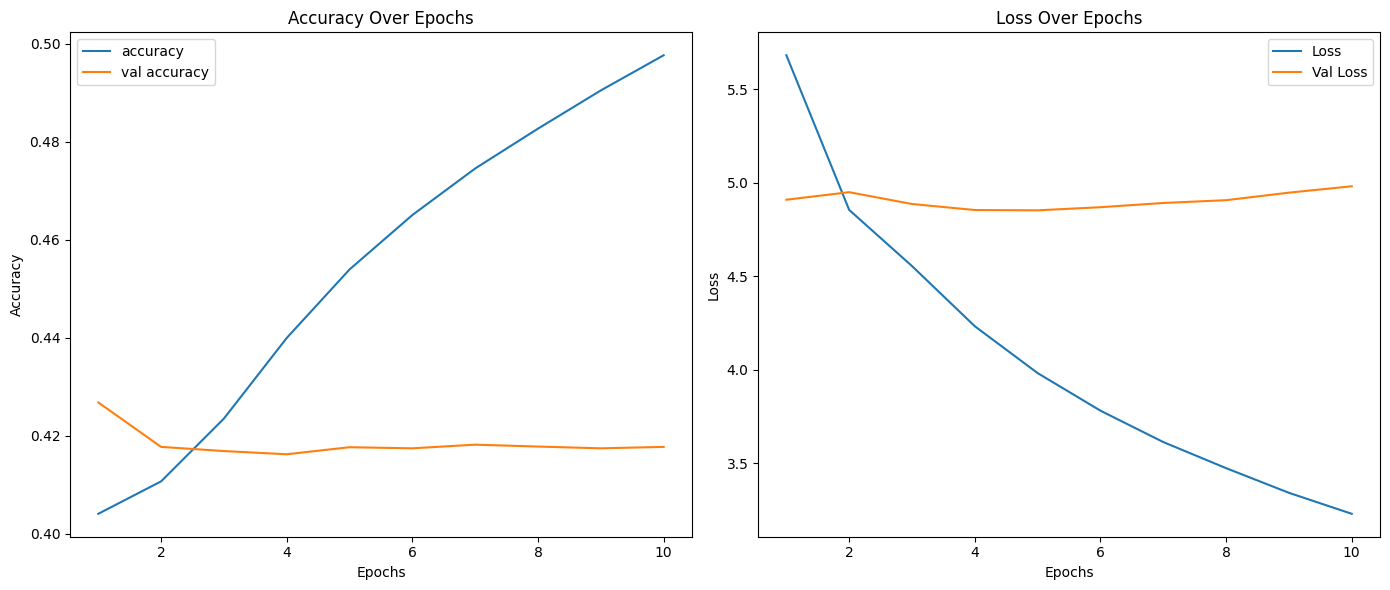

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(14, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='accuracy')
plt.plot(epochs, val_accuracy, label='val accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Summary generation function
def generate_summaries(X_test, model, tokenizer, max_article_len, max_summary_len):
    generated_summaries = []
    for article_seq in X_test:
        article_seq = pad_sequences([article_seq], maxlen=max_article_len, padding='post')
        summary_seq = [0]  # Start token

        for _ in range(max_summary_len):
            # Predict next token
            output = model.predict([article_seq, pad_sequences([summary_seq], maxlen=max_summary_len, padding='post')], verbose=0)
            next_token = np.argmax(output[0, len(summary_seq) - 1, :])

            # Stop if the end-of-sequence or padding token is predicted
            if next_token == 0:
                break
            summary_seq.append(next_token)

        # Decode generated summary into text
        generated_summaries.append(' '.join(tokenizer.index_word.get(i, '') for i in summary_seq[1:]))
    return generated_summaries

def decode_references(Y_test, tokenizer):
    references = []
    for seq in Y_test:
        reference = ' '.join([tokenizer.index_word.get(idx, '') for idx in seq if idx != 0])
        references.append(reference)
    return references

# Convert test articles and summaries to sequences
X_test = texts_to_sequences(test_articles[:25], max_length=max_article_len)
Y_test = texts_to_sequences(test_summaries[:25], max_length=max_summary_len)

In [ ]:
# Function to compute ROUGE scores
def compute_rouge(references, candidates):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    for ref, cand in zip(references, candidates):
        score = scorer.score(ref, cand)
        scores['rouge1'].append(score['rouge1'].fmeasure)
        scores['rouge2'].append(score['rouge2'].fmeasure)
        scores['rougeL'].append(score['rougeL'].fmeasure)

    # Average the scores
    avg_scores = {metric: np.mean(values) for metric, values in scores.items()}
    return avg_scores

In [ ]:
print("Generating summaries for the test set...")
generated_summaries = generate_summaries(X_test, model, tokenizer, max_article_len, max_summary_len)
reference_summaries = decode_references(Y_test, tokenizer)

print("Evaluating ROUGE scores...")
rouge_scores = compute_rouge(reference_summaries, generated_summaries)

print(f"ROUGE-1: {rouge_scores['rouge1']:.4f}, ROUGE-2: {rouge_scores['rouge2']:.4f}, ROUGE-L: {rouge_scores['rougeL']:.4f}")

Generating summaries for the test set...
Evaluating ROUGE scores...
ROUGE-1: 0.0364, ROUGE-2: 0.0064, ROUGE-L: 0.0312


In [ ]:
for i in range(0,5):
    print(f"--- Example {i+1} ---")
    print(f"Original Article: {test_articles[i][:200]}...")
    print(f"Generated Summary: {generated_summaries[i]}")
    print(f"Reference Summary: {reference_summaries[i]}")
    print()

--- Example 1 ---
Original Article: Jakarta , CNN Indonesia - - Dilansir AFP , seorang warga Mesir yang dipercaya sebagai wanita terberat di dunia masuk sebuah rumah sakit di Abu Dhabi Kamis ( 5 / 5 ) , dimana ia akan melanjutkan perawa...
Generated Summary:   menteri koordinator bidang perekonomian darmin nasution mengatakan bahwa pihaknya akan segera memeriksa sejumlah saksi untuk tersangka anang sugiana sudihardjo
Reference Summary: eman ahmed abd el memiliki berat badan mencapai 500 kilogram sebelum menjalankan operasi di mumbai maret lalu dimana ia mengurangi seperlima dari berat badannya abd el diberi diet cairan khusus selama berada di india yang bertujuan menurunkan berat badan kini berat badannya telah turun drastis sebanyak 323 kilogram dalam tiga bulan sekarang berat badannya tinggal 176 6 kilogram

--- Example 2 ---
Original Article: Menteri Pertahanan Ryamizard Ryacudu menyambut baik usulan pembelian drone dari China untuk dikembangkan di Indonesia . Pesawat tanpa awak itu

## LSTM

In [ ]:
# Encoder
encoder2_inputs = Input(shape=(max_article_len,))
encoder2_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(encoder2_inputs)
encoder2_rnn = LSTM(rnn_units, return_sequences=False)(encoder2_embedding)
encoder2_output = Dense(rnn_units)(encoder2_rnn)

# Decoder
decoder2_inputs = Input(shape=(max_summary_len,))
decoder2_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(decoder2_inputs)
decoder2_rnn = LSTM(rnn_units, return_sequences=True)(decoder2_embedding, initial_state=[encoder2_output, encoder2_output])  # LSTM requires both hidden and cell states
decoder2_outputs = Dense(vocab_size, activation='softmax')(decoder2_rnn)

# Define the model
model_lstm = Model([encoder2_inputs, decoder2_inputs], decoder2_outputs)
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_lstm.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 500)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 500, 128)       │     12,122,752 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        394,240 │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 100, 128)       │     12,122,752 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │         65,792 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 100, 256)       │        394,240 │ embedding_4[0][0],     │
│                           │                        │                │ dense_2[0][0],         │
│                           │                        │                │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 100, 94709)     │     24,340,213 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 49,439,989 (188.60 MB)

 Trainable params: 49,439,989 (188.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_lstm = model_lstm.fit([X_train, Y_train_in], Y_train_out, batch_size=batch_size, epochs=10, validation_data=([X_dev, Y_dev], np.expand_dims(Y_dev, -1)))

Epoch 1/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.4059 - loss: 6.8923Epoch 2/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 202s 893ms/step - accuracy: 0.4117 - loss: 4.8850 - val_accuracy: 0.4256 - val_loss: 4.8943
Epoch 3/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 202s 894ms/step - accuracy: 0.4192 - loss: 4.7832 - val_accuracy: 0.4165 - val_loss: 4.8797
Epoch 4/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 202s 894ms/step - accuracy: 0.4225 - loss: 4.6657 - val_accuracy: 0.4147 - val_loss: 4.9049
Epoch 5/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 202s 895ms/step - accuracy: 0.4258 - loss: 4.5633 - val_accuracy: 0.4151 - val_loss: 4.8910
Epoch 6/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 202s 897ms/step - accuracy: 0.4314 - loss: 4.4176 - val_accuracy: 0.4153 - val_loss: 4.8552
Epoch 7/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 202s 897ms/step - accuracy: 0.4393 - loss: 4.2413 - val_accuracy: 0.4157 - val_loss: 4.8260
Epoch 8/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 202s 896ms/step - accuracy: 0.4480 - loss: 4.0773 - val_accuracy: 0.4158 - val_lo

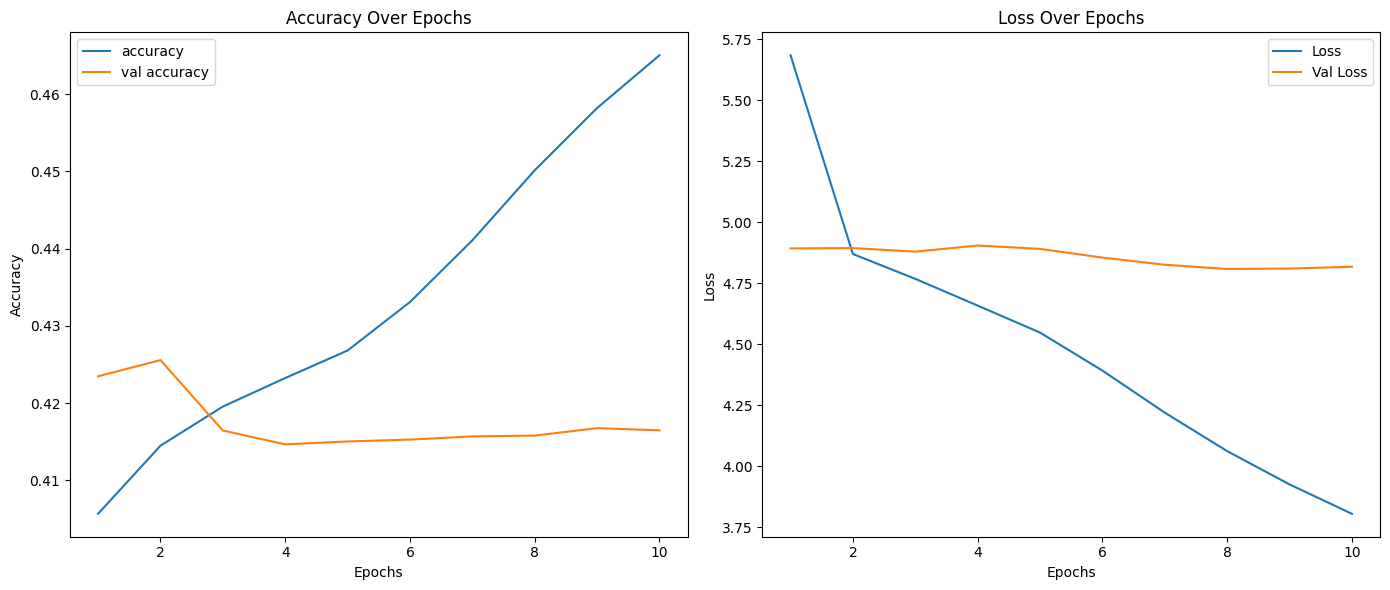

In [ ]:
accuracy_lstm = history_lstm.history["accuracy"]
val_accuracy_lstm = history_lstm.history["val_accuracy"]
loss_lstm = history_lstm.history["loss"]
val_loss_lstm = history_lstm.history["val_loss"]

plt.figure(figsize=(14, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy_lstm, label='accuracy')
plt.plot(epochs, val_accuracy_lstm, label='val accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss_lstm, label='Loss')
plt.plot(epochs, val_loss_lstm, label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

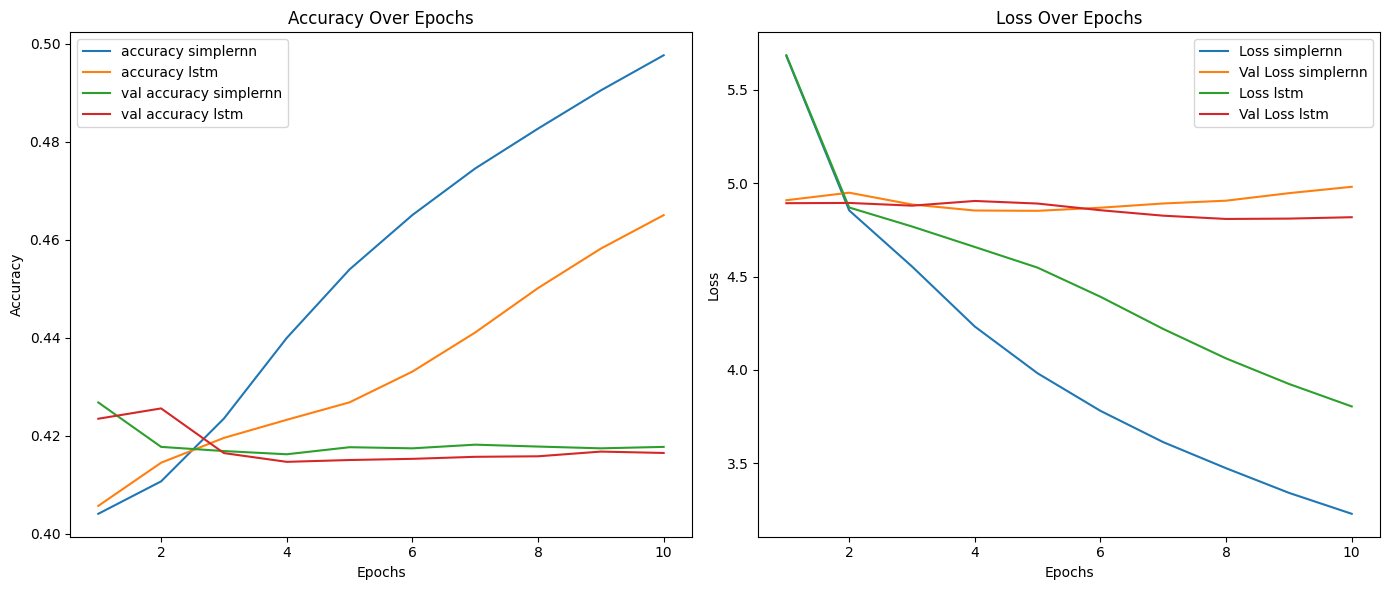

In [ ]:
plt.figure(figsize=(14, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='accuracy simplernn')
plt.plot(epochs, accuracy_lstm, label='accuracy lstm')
plt.plot(epochs, val_accuracy, label='val accuracy simplernn')
plt.plot(epochs, val_accuracy_lstm, label='val accuracy lstm')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Loss simplernn')
plt.plot(epochs, val_loss, label='Val Loss simplernn')
plt.plot(epochs, loss_lstm, label='Loss lstm')
plt.plot(epochs, val_loss_lstm, label='Val Loss lstm')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print("Generating summaries for the test set...")
generated_summaries = generate_summaries(X_test, model_lstm, tokenizer, max_article_len, max_summary_len)
reference_summaries = decode_references(Y_test, tokenizer)

print("Evaluating ROUGE scores...")
rouge_scores = compute_rouge(reference_summaries, generated_summaries)

print(f"ROUGE-1: {rouge_scores['rouge1']:.4f}, ROUGE-2: {rouge_scores['rouge2']:.4f}, ROUGE-L: {rouge_scores['rougeL']:.4f}")

Generating summaries for the test set...
Evaluating ROUGE scores...
ROUGE-1: 0.0788, ROUGE-2: 0.0035, ROUGE-L: 0.0640


In [ ]:
for i in range(0,5):
    print(f"--- Example {i+1} ---")
    print(f"Original Article: {test_articles[i][:200]}...")
    print(f"Generated Summary: {generated_summaries[i]}")
    print(f"Reference Summary: {reference_summaries[i]}")
    print()

--- Example 1 ---
Original Article: Jakarta , CNN Indonesia - - Dilansir AFP , seorang warga Mesir yang dipercaya sebagai wanita terberat di dunia masuk sebuah rumah sakit di Abu Dhabi Kamis ( 5 / 5 ) , dimana ia akan melanjutkan perawa...
Generated Summary:     indonesia dan merilis sebuah lagu yang akan digelar di indonesia pada jumat 10 10 2017 di indonesia pada senin 10 10 malam wib yang akan digelar di indonesia pada jumat 10 10 malam waktu setempat di indonesia pada jumat 10 10 malam waktu setempat di indonesia pada jumat 10 10 malam waktu setempat di indonesia
Reference Summary: eman ahmed abd el memiliki berat badan mencapai 500 kilogram sebelum menjalankan operasi di mumbai maret lalu dimana ia mengurangi seperlima dari berat badannya abd el diberi diet cairan khusus selama berada di india yang bertujuan menurunkan berat badan kini berat badannya telah turun drastis sebanyak 323 kilogram dalam tiga bulan sekarang berat badannya tinggal 176 6 kilogram

--- Example 2 ---
Origina